In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from statsmodels.stats.proportion import proportions_ztest
%matplotlib inline

# Исследуем датасет 

In [2]:
df = pd.read_csv('ab_test_results_aggregated_views_clicks_2.csv')
df.head()

,user_id,group,views,clicks
0,1,control,10.0,0.0
1,2,control,1.0,0.0
2,3,control,1.0,0.0
3,4,control,2.0,0.0
4,5,control,3.0,0.0


In [3]:
# Размер датасета
df.shape

(120000, 4)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120000 entries, 0 to 119999
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   user_id  120000 non-null  int64  
 1   group    120000 non-null  object 
 2   views    120000 non-null  float64
 3   clicks   120000 non-null  float64
dtypes: float64(2), int64(1), object(1)
memory usage: 3.7+ MB


In [7]:
df.describe()

,user_id,views,clicks
count,120000.000000,120000.000000,120000.000000
mean,60000.500000,4.991075,0.182692
std,34641.160489,5.915200,0.472547
min,1.000000,1.000000,0.000000
25%,30000.750000,2.000000,0.000000
50%,60000.500000,3.000000,0.000000
75%,90000.250000,6.000000,0.000000
max,120000.000000,205.000000,9.000000


In [8]:
# Кол-во пользователей в 2-х группах

df.groupby('group')['user_id'].count()

group
control    60000
test       60000
Name: user_id, dtype: int64

In [9]:
# Среднее кол-во просмотров

df.groupby('group')['views'].mean()

group
control    4.95240
test       5.02975
Name: views, dtype: float64

In [10]:
# Среднее кол-во кликов

df.groupby('group')['clicks'].mean()

group
control    0.171717
test       0.193667
Name: clicks, dtype: float64

* Нулевая гипотеза: Кол-во просмотров и кликов в тестовой группе не отличается от контрольной группы.
* Альтернативная гипотеза: Кол-во просмотров и кликов в тестовой группе больше просмотров и кликов в контрольной группе

# z-test для  views

In [12]:
control = df[df['group'] == 'control']
test = df[df['group'] == 'test']

In [21]:
ns1_views = sum(control['views']) # общее кол-во просмотров в контрольной группе
ns2_views = sum(test['views']) # общее кол-во просмотров в тестовой группе

n = control.shape[0] # размер группы (у нас равное кол-во человек)

sucs = np.array([ns1_views, ns2_views]) # массив суммы действий
count = np.array([n, n]) # массив кол-ва человек

In [23]:
# z-test для views

stat, o_p = proportions_ztest(count, sucs)

p_value_views = o_p/2

print('p-value: ', p_value_views)

p-value:  0.0013416302983786472


z-test для views показал что p-value меньше уровня значимости в 5 %, нулевая гипотеза для views отвергается

#  z-test для  clicks

In [24]:
ns1_clicks = sum(control['clicks']) # общее кол-во кликов в контрольной группе
ns2_clicks = sum(test['clicks']) # общее кол-во кликов в тестовой группе

n = control.shape[0] # размер группы (у нас равное кол-во человек)

sucs = np.array([ns1_clicks, ns2_clicks]) # массив суммы действий
count = np.array([n, n]) # массив кол-ва человек

In [25]:
# z-test для clicks

stat, o_p = proportions_ztest(sucs, count)

p_value_views = o_p/2

print('p-value: ', p_value_views)

p-value:  3.830369173235639e-23


z-test для clicks показал что p-value меньше уровня значимости в 5 %, нулевая гипотеза для clicks отвергается

Для подтверждения наших выводов необходимо применить bootstrap

# А/Б тест bootstrap для views

In [35]:
# Получаем значения столбца views для control и test

views_control = control['views'].values
views_test = test['views'].values

p_control = views_control.mean() # конверсия контрольной группы
p_test = views_test.mean() # конверсия тестовой группы

dif = p_test- p_control # разница в долях конверсий

N = 1500

In [39]:
# Бутстреп для views

differences = np.zeros(N)

for i in range(0, N):
    s1 = random.choices(views_control, k = len(views_control))
    s2 = random.choices(views_test, k = len(views_test))
    p1 = np.mean(s1)
    p2 = np.mean(s2)
    differences[i] = p2 - p1
    
p_value = sum(differences >= dif) / N

p_value

0.496

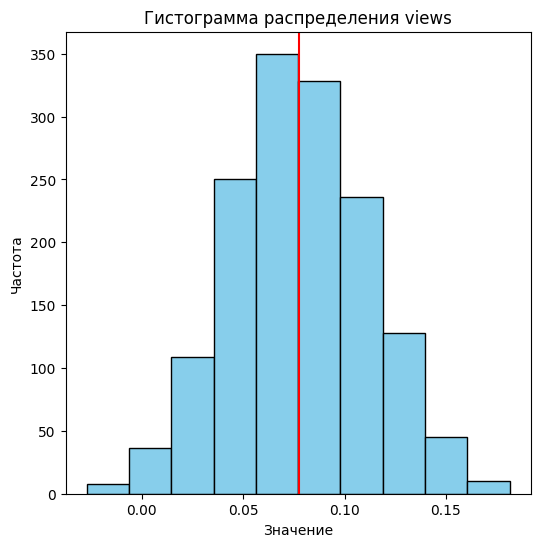

In [48]:
# Гистограмма 

plt.figure(figsize = (6, 6))
plt.hist(differences, color = 'skyblue', edgecolor = 'black')
plt.axvline(x = dif, color = 'red')
plt.title('Гистограмма распределения views')
plt.xlabel('Значение')
plt.ylabel('Частота')

plt.show()

Как видно из на графике, гистограмма смещена в право относительно 0. Необходимо центрировать данные

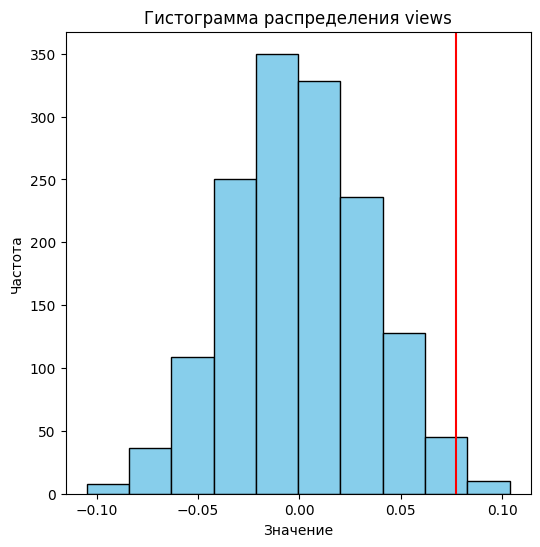

In [49]:
plt.figure(figsize = (6, 6))
plt.hist(differences - np.mean(differences), color = 'skyblue', edgecolor = 'black')
plt.axvline(x = dif, color = 'red')
plt.title('Гистограмма распределения views')
plt.xlabel('Значение')
plt.ylabel('Частота')

plt.show()

In [44]:
p_value_cent = sum((differences - np.mean(differences)) > dif) / N

p_value_cent

0.011333333333333334

bootstrap для views показал что p-value меньше уровня значимости в 5 %, нулевая гипотеза для clicks отвергается

#  А/Б тест bootstrap для clicks

In [50]:
# Получаем значения столбца clicks для control и test

clicks_control = control['clicks'].values
clicks_test = test['clicks'].values

p_control = clicks_control.mean() # конверсия контрольной группы
p_test = clicks_test.mean() # конверсия тестовой группы

dif = p_test- p_control # разница в долях конверсий

N = 1500

In [51]:
# Бутстреп для clicks

differences = np.zeros(N)

for i in range(0, N):
    s1 = random.choices(clicks_control, k = len(clicks_control))
    s2 = random.choices(clicks_test, k = len(clicks_test))
    p1 = np.mean(s1)
    p2 = np.mean(s2)
    differences[i] = p2 - p1
    
p_value = sum(differences >= dif) / N

p_value

0.506

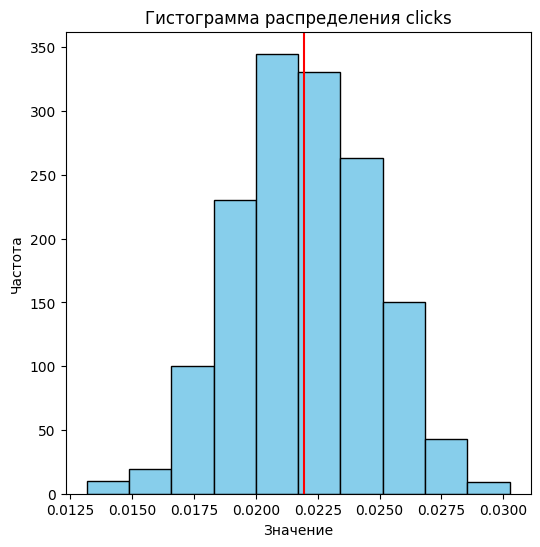

In [52]:
# Гистограмма 

plt.figure(figsize = (6, 6))
plt.hist(differences, color = 'skyblue', edgecolor = 'black')
plt.axvline(x = dif, color = 'red')
plt.title('Гистограмма распределения clicks')
plt.xlabel('Значение')
plt.ylabel('Частота')

plt.show()

Как видно из на графике, гистограмма смещена в право относительно 0. Необходимо центрировать данные

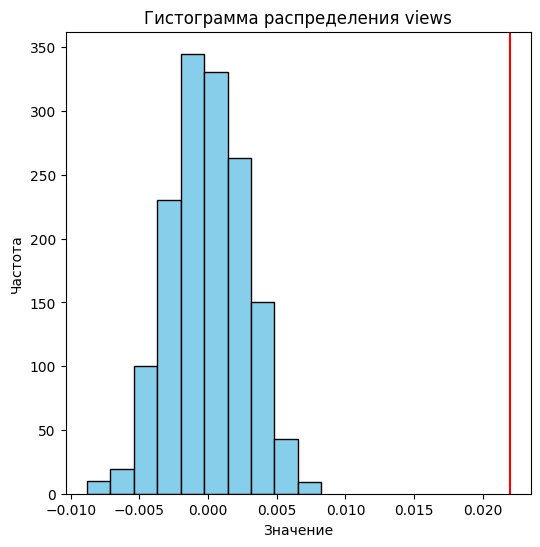

In [54]:
plt.figure(figsize = (6, 6))
plt.hist(differences - np.mean(differences), color = 'skyblue', edgecolor = 'black')
plt.axvline(x = dif, color = 'red')
plt.title('Гистограмма распределения views')
plt.xlabel('Значение')
plt.ylabel('Частота')

plt.show()

In [55]:
p_value_cent = sum((differences - np.mean(differences)) > dif) / N

p_value_cent

0.0

bootstrap для views показал что p-value меньше уровня значимости в 5 %, нулевая гипотеза для clicks отвергается

# Вывод

Итак, результаты бутстрапа и z-теста говорят нам о том, что внедрение новоего дизайна сайта оправдано и выгодно.